In [42]:
import torch
from modules.data_utils import load_all_slices_from_tree

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[Device] {device}")

[Device] cuda


In [43]:
# 1) 데이터 로드
data_root = './01_data/04_flair_preproc_slices/'
X, y = load_all_slices_from_tree(data_root, select_N=100)
print(f"[Loaded] total={len(y)} | pos={(y==1).sum()} | neg={(y==0).sum()}")

[Loaded] subjects=100, total_slices=2384, pos=22, neg=2362
[Loaded] total=2384 | pos=22 | neg=2362


In [44]:
from modules.data_utils import undersample_negatives
neg_ratio = 1.0
X_bal, y_bal = undersample_negatives(X, y, neg_ratio=neg_ratio)
print(f"[Balanced] total={len(y_bal)} | pos={(y_bal==1).sum()} | neg={(y_bal==0).sum()} (neg_ratio={neg_ratio})")

[Balanced] total=44 | pos=22 | neg=22 (neg_ratio=1.0)


In [46]:
import numpy as np
import os

from modules.data_utils import train_test_split_stratified, train_val_split_stratified
test_ratio = 0.3
val_ratio = 0.1
seed = 42
out_dir = './02_results/test'

# 3) train/test split then train/val split
(Xtr_full, ytr_full), (Xte, yte) = train_test_split_stratified(X_bal, y_bal, test_ratio=test_ratio, seed=seed)
(Xtr, ytr), (Xval, yval) = train_val_split_stratified(Xtr_full, ytr_full, val_ratio=val_ratio, seed=seed)
print(f"[Split] train={len(ytr)} | val={len(yval)} | test={len(yte)} (test_ratio={test_ratio}, val_ratio={val_ratio})")
# np.save(os.path.join(out_dir, "test_data.npy"), Xte)

[Split] train=30 | val=2 | test=12 (test_ratio=0.3, val_ratio=0.1)


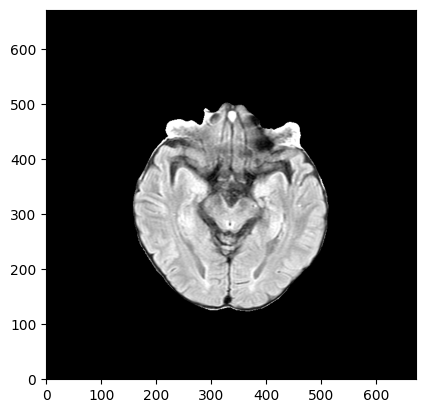

In [55]:
import matplotlib.pyplot as plt

path_npy = '/zdisk/users/ext_user_03/01_yschoi/project_01_FVH_detection/01_data/04_flair_preproc_slices_rot/HP00892_P07762/HP00892_P07762_AxialSlices_padded.npy'
npy = np.load(path_npy)
plt.imshow(npy[10].T, cmap='grey', origin='lower')

In [ ]:
from modules.data_utils import SliceDataset

# 4) Datasets & Dataloaders
ds_train = SliceDataset(Xtr, ytr)
ds_val   = SliceDataset(Xval, yval)
ds_test  = SliceDataset(Xte, yte)

In [ ]:
Xte[0][300:310, 300:310]

array([[0.5726022 , 0.535956  , 0.56706005, 0.64443666, 0.697198  ,
        0.672835  , 0.61755675, 0.6301762 , 0.69532704, 0.72650516],
       [0.52699256, 0.50261253, 0.56458   , 0.6790737 , 0.74734336,
        0.7353311 , 0.66765344, 0.64628613, 0.6743821 , 0.6746309 ],
       [0.5460578 , 0.5185724 , 0.5651675 , 0.67050606, 0.75429344,
        0.7670083 , 0.71783435, 0.6778881 , 0.6533762 , 0.6226344 ],
       [0.5898529 , 0.5592696 , 0.578106  , 0.6526229 , 0.72719705,
        0.7491937 , 0.7402203 , 0.70643437, 0.65090775, 0.6015253 ],
       [0.65535825, 0.64024013, 0.63128173, 0.6315886 , 0.6628559 ,
        0.694136  , 0.72232616, 0.7195078 , 0.67323464, 0.6238077 ],
       [0.7085948 , 0.7182532 , 0.69073606, 0.62289006, 0.60147166,
        0.62964725, 0.676449  , 0.7015415 , 0.68626595, 0.6585365 ],
       [0.7061602 , 0.75300723, 0.7378784 , 0.6513767 , 0.5771926 ,
        0.57433337, 0.62425506, 0.6679856 , 0.6837583 , 0.6870872 ],
       [0.6509977 , 0.7443777 , 0.769566 

In [ ]:
ds_test.images[0][300:310, 300:310]

array([[0.5726022 , 0.535956  , 0.56706005, 0.64443666, 0.697198  ,
        0.672835  , 0.61755675, 0.6301762 , 0.69532704, 0.72650516],
       [0.52699256, 0.50261253, 0.56458   , 0.6790737 , 0.74734336,
        0.7353311 , 0.66765344, 0.64628613, 0.6743821 , 0.6746309 ],
       [0.5460578 , 0.5185724 , 0.5651675 , 0.67050606, 0.75429344,
        0.7670083 , 0.71783435, 0.6778881 , 0.6533762 , 0.6226344 ],
       [0.5898529 , 0.5592696 , 0.578106  , 0.6526229 , 0.72719705,
        0.7491937 , 0.7402203 , 0.70643437, 0.65090775, 0.6015253 ],
       [0.65535825, 0.64024013, 0.63128173, 0.6315886 , 0.6628559 ,
        0.694136  , 0.72232616, 0.7195078 , 0.67323464, 0.6238077 ],
       [0.7085948 , 0.7182532 , 0.69073606, 0.62289006, 0.60147166,
        0.62964725, 0.676449  , 0.7015415 , 0.68626595, 0.6585365 ],
       [0.7061602 , 0.75300723, 0.7378784 , 0.6513767 , 0.5771926 ,
        0.57433337, 0.62425506, 0.6679856 , 0.6837583 , 0.6870872 ],
       [0.6509977 , 0.7443777 , 0.769566 

In [ ]:
from torch.utils.data import DataLoader

batch_size = 16
num_workers = 4

dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True,
                        num_workers=num_workers, pin_memory=False,
                        persistent_workers=False if num_workers == 0 else True)
dl_val   = DataLoader(ds_val, batch_size=batch_size, shuffle=False,
                        num_workers=num_workers, pin_memory=False,
                        persistent_workers=False if num_workers == 0 else True)
dl_test  = DataLoader(ds_test,  batch_size=batch_size, shuffle=False,
                        num_workers=num_workers, pin_memory=False,
                        persistent_workers=False if num_workers == 0 else True)

In [ ]:
dl_test.dataset.labels.shape

(12,)

In [ ]:
len(dl_train.dataset)

30

In [ ]:
for img, lab in dl_train:
    print(img.shape, lab.shape)

torch.Size([16, 1, 672, 672]) torch.Size([16])
torch.Size([14, 1, 672, 672]) torch.Size([14])


In [ ]:
from modules.model_utils import *

weight_pos = 1.0
lr = 0.003

# 5) 모델/손실/최적화
model = build_resnet18_1ch(num_classes=1).to(device)
pos_weight = torch.tensor([weight_pos], device=device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
pos_weight

tensor([1.], device='cuda:0')

In [ ]:
criterion

BCEWithLogitsLoss()